In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC/Base_Files/full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
48166,NaN,NaN,International,2020-10-03,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48167,NaN,NaN,International,2020-10-04,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48168,NaN,NaN,International,2020-10-05,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


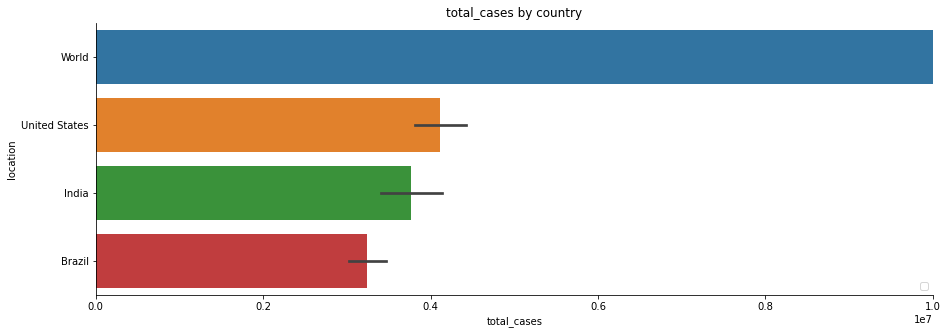

In [13]:
worldrep("total_cases",graph_long=5,val_larg=10000000)

No handles with labels found to put in legend.


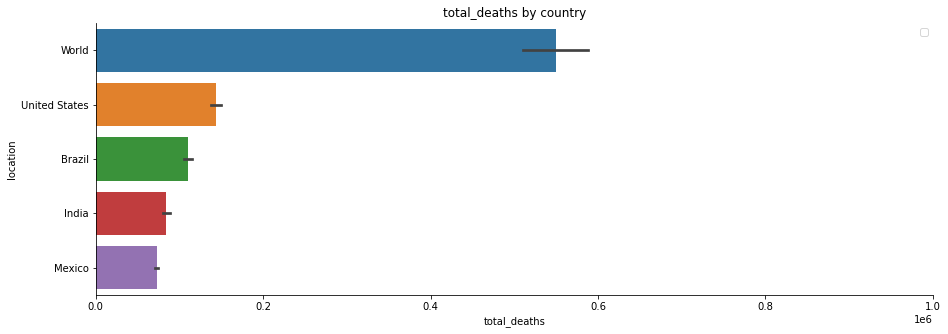

In [14]:
worldrep("total_deaths",val_larg=1000000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


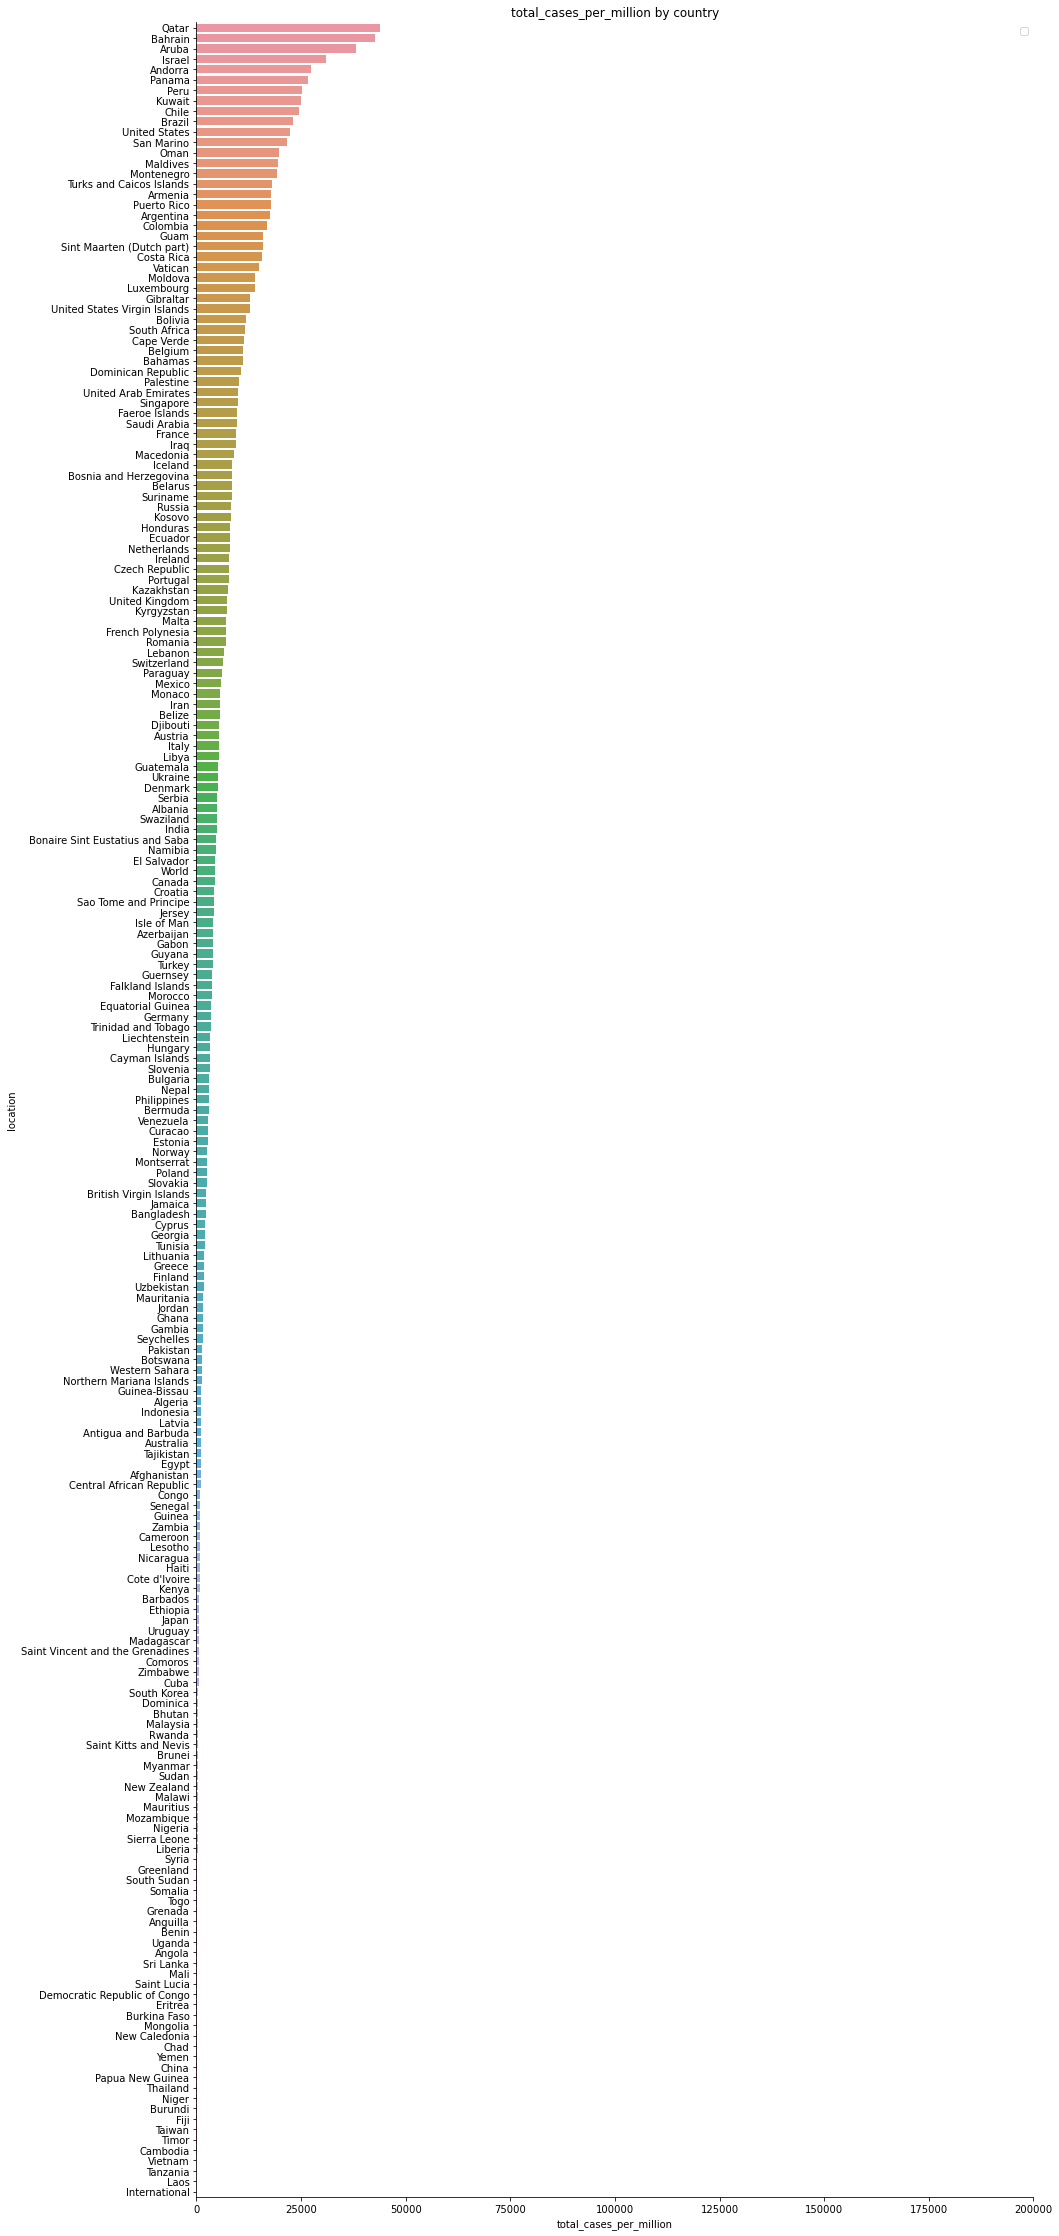

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=200000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


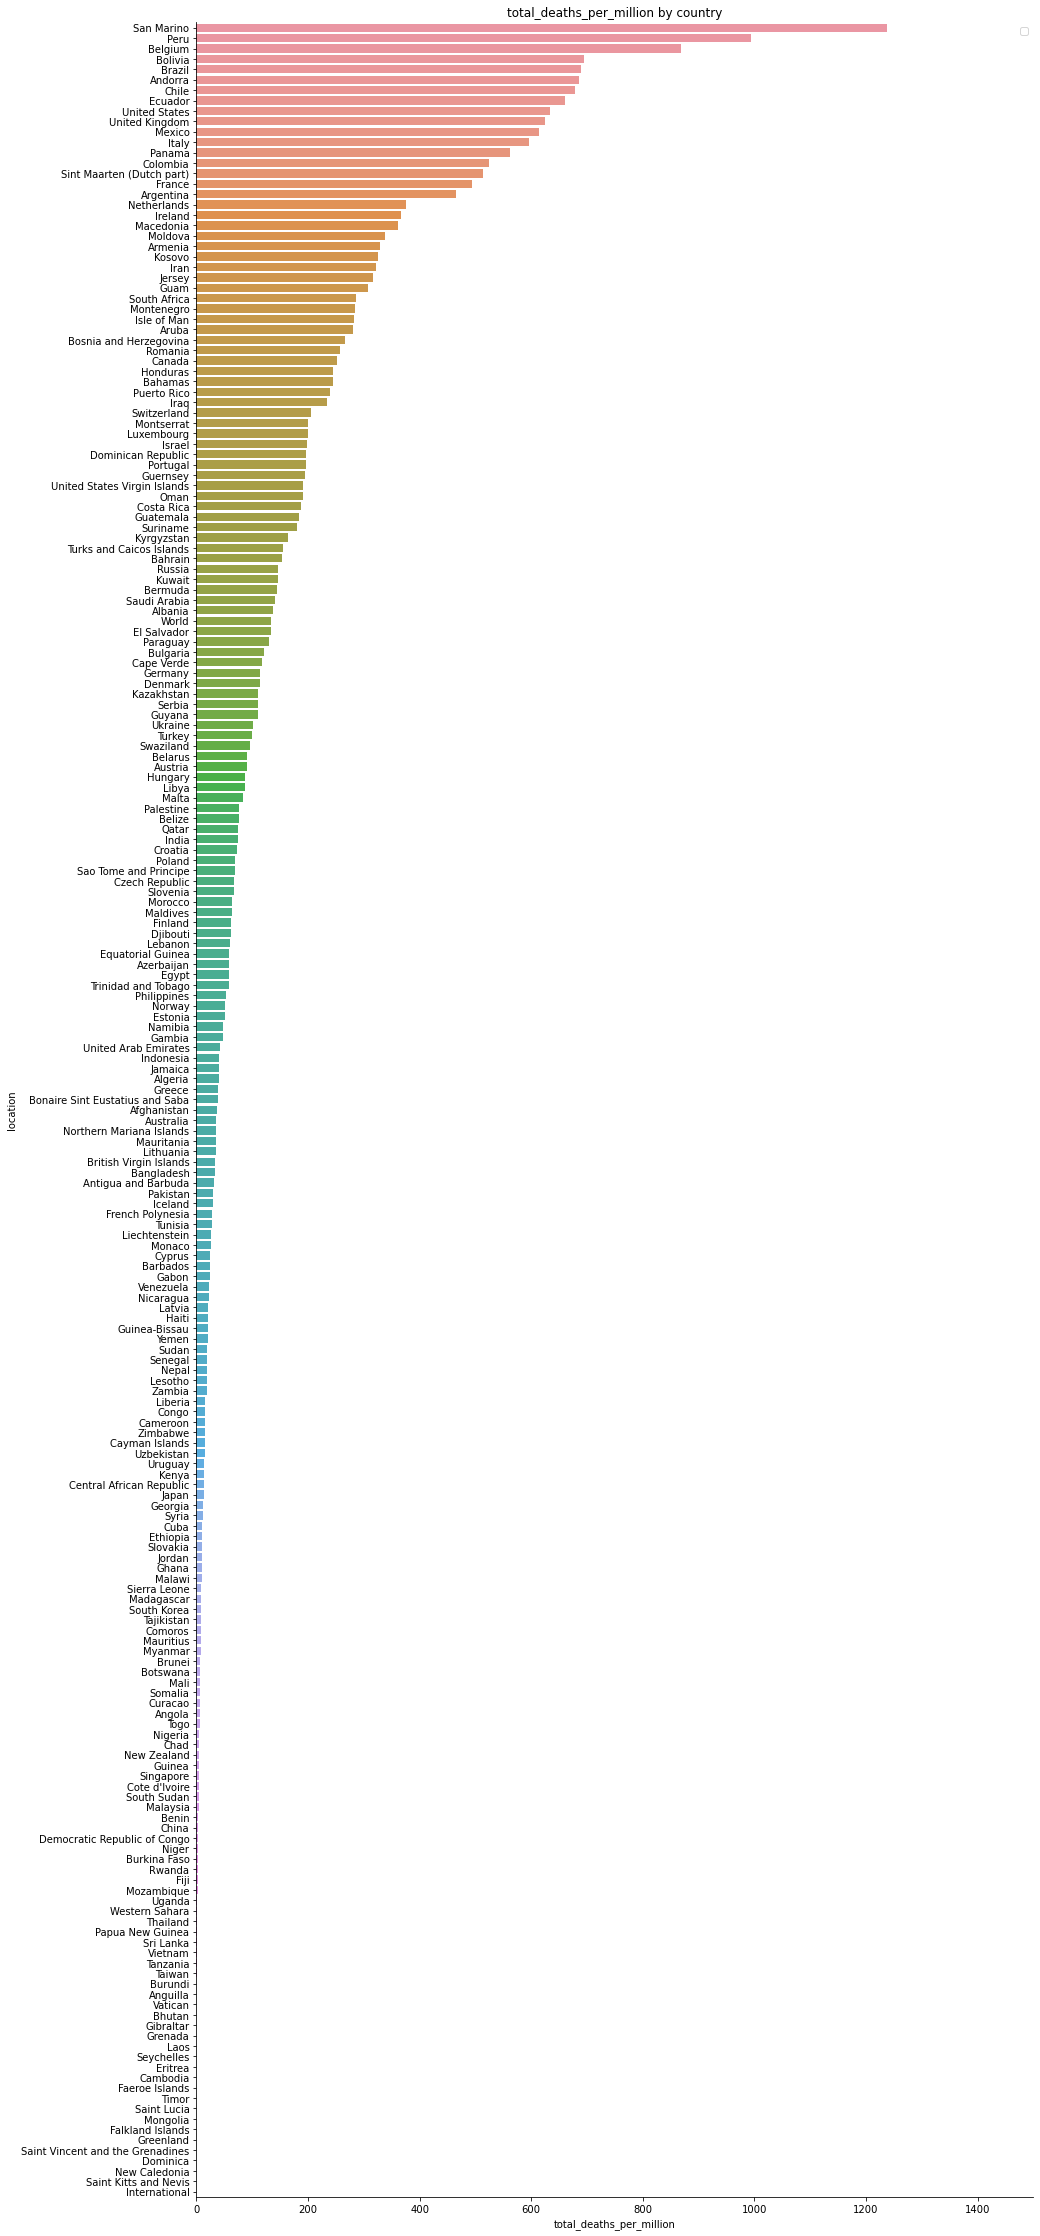

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

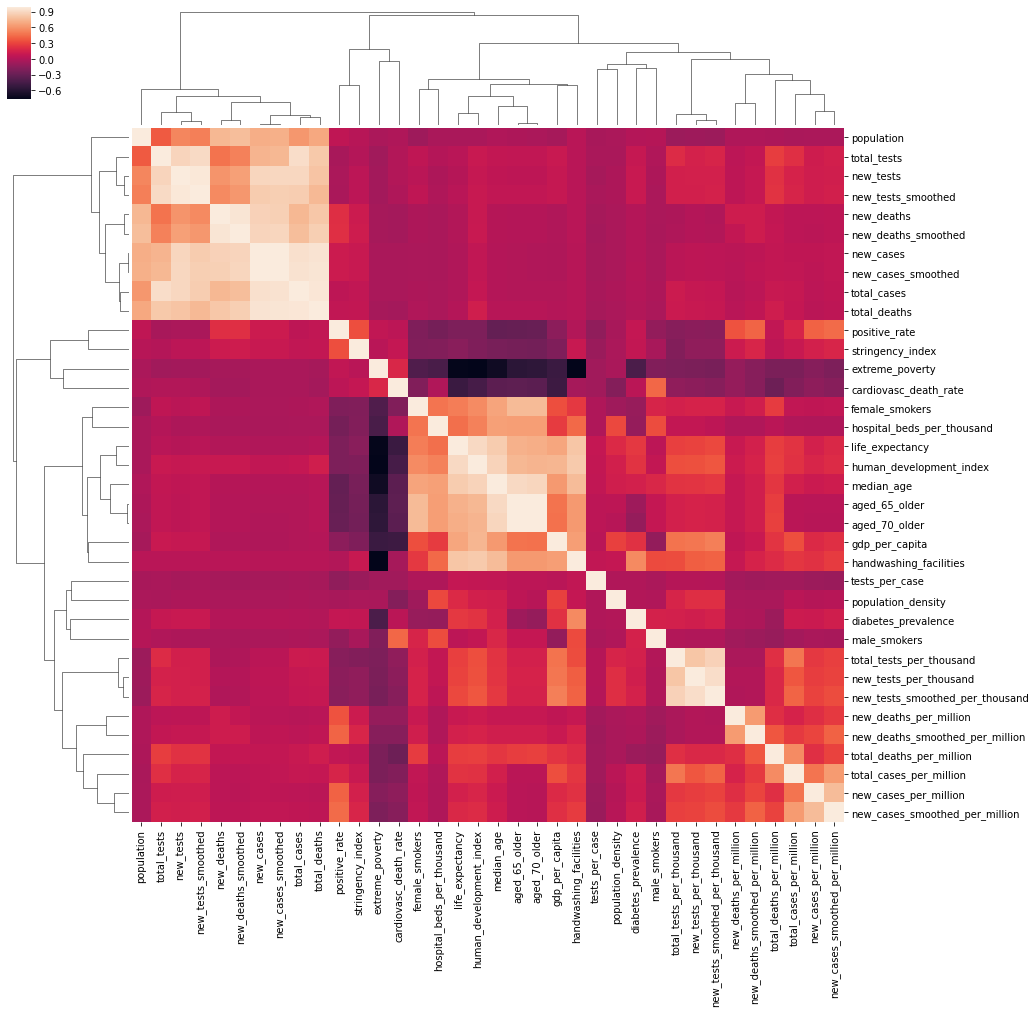

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9968978909939219 (+/- 0.004266300990858105)
Coef :  [1.02909315e+00 7.42633292e-05 7.62824270e-05]
3 Last_days :  [[34686054 34988624 35247104]]
Today :  35247104
Prediction + :  568774
Tomorow :  35815878
                                     
--------- Total Death -----------------
                                     
R^2: 0.999551592983178 (+/- 0.0002267555687562653)
Coef :  [0.30148474 0.34404059 0.36429987]
3 Last_days :  [[1029538 1034255 1038069]]
Today :  1038069
Prediction + :  10019
Tomorow :  1048088
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7546200211480968 (+/- 0.34281302918962675)
Coef :  [-0.6621134   0.72390727  0.946871  ]
3 Last_days :  [[589653 606625 619170]]
Today :  619170
Prediction + :  15566
Tomorow :  634736
                                     
--------- Total Death -----------------
                                     
R^2: 0.6196576857663153 (+/- 0.5313255096610721)
Coef :  [-0.74183093  0.78644437  0.95433562]
3 Last_days :  [[32155 32198 32230]]
Today :  32230
Prediction + :  51
Tomorow :  32281
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9745673269600904 (+/- 0.030622158419458794)
Coef :  [-0.33262995 -0.00549849  1.33239426]
3 Last_days :  [[90584 90604 90629]]
Today :  90629
Prediction + :  22
Tomorow :  90651
                                     
--------- Total Death -----------------
                                     
R^2: -6.520157736183535 (+/- 10.525376574457514)
Coef :  [-0.07795847  0.01250789  1.05705735]
3 Last_days :  [[4739 4739 4739]]
Today :  4739
Prediction + :  5
Tomorow :  4744
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8834163035181692 (+/- 0.1636858334456691)
Coef :  [-0.802238    0.88719962  0.91473033]
3 Last_days :  [[319908 322751 325329]]
Today :  325329
Prediction + :  2358
Tomorow :  327687
                                     
--------- Total Death -----------------
                                     
R^2: 0.2780098073973712 (+/- 1.0066808145043697)
Coef :  [-0.81490375  0.89297027  0.92088132]
3 Last_days :  [[35941 35968 35986]]
Today :  35986
Prediction + :  40
Tomorow :  36026
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.44633873208861696 (+/- 2.0326818757366563)
Coef :  [-0.22390107  0.17192153  1.06073464]
3 Last_days :  [[789932 789932 789932]]
Today :  789932
Prediction + :  7066
Tomorow :  796998
                                     
--------- Total Death -----------------
                                     
R^2: -1.0452224500125695 (+/- 2.6160047098969748)
Coef :  [-0.73174589  0.65085544  1.07991635]
3 Last_days :  [[32086 32086 32086]]
Today :  32086
Prediction + :  8
Tomorow :  32094
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8817089340818455 (+/- 0.16247280758773128)
Coef :  [0.21920025 0.39414508 0.39885205]
3 Last_days :  [[7332285 7382944 7417845]]
Today :  7417845
Prediction + :  79178
Tomorow :  7497023
                                     
--------- Total Death -----------------
                                     
R^2: 0.9914271433511758 (+/- 0.01086602132568308)
Coef :  [-0.31915826  0.63309805  0.68879744]
3 Last_days :  [[208716 209394 209794]]
Today :  209794
Prediction + :  1189
Tomorow :  210983
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.907840528370417 (+/- 0.127954469152427)
Coef :  [-0.81944703  0.84133856  0.9802219 ]
3 Last_days :  [[467146 480017 502978]]
Today :  502978
Prediction + :  11195
Tomorow :  514173
                                     
--------- Total Death -----------------
                                     
R^2: 0.7094201414462346 (+/- 0.39426362800204995)
Coef :  [-0.75870689  0.82817588  0.92972551]
3 Last_days :  [[42268 42317 42350]]
Today :  42350
Prediction + :  67
Tomorow :  42417
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9544852131509837 (+/- 0.06353597403158609)
Coef :  [-0.76038062  0.84132148  0.91927181]
3 Last_days :  [[296958 299237 300619]]
Today :  300619
Prediction + :  2013
Tomorow :  302632
                                     
--------- Total Death -----------------
                                     
R^2: 0.15032786669227896 (+/- 1.1954908237454573)
Coef :  [-0.7784324   0.83697732  0.94060591]
3 Last_days :  [[9527 9529 9534]]
Today :  9534
Prediction + :  7
Tomorow :  9541
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9970922171301857 (+/- 0.0027844309826936453)
Coef :  [0.4436703  0.28644101 0.28205899]
3 Last_days :  [[464596 468119 471772]]
Today :  471772
Prediction + :  3219
Tomorow :  474991
                                     
--------- Total Death -----------------
                                     
R^2: 0.9088434428256402 (+/- 0.12782552276128736)
Coef :  [0.27831524 0.37334227 0.36033025]
3 Last_days :  [[26567 26746 26957]]
Today :  26957
Prediction + :  215
Tomorow :  27172
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9997830407963376 (+/- 0.0001024503657002337)
Coef :  [-0.54134183  0.75830437  0.78034978]
3 Last_days :  [[321512 323014 324443]]
Today :  324443
Prediction + :  1198
Tomorow :  325641
                                     
--------- Total Death -----------------
                                     
R^2: 0.999521531026936 (+/- 0.00033161480030188546)
Coef :  [-0.81151525  0.89651981  0.91375044]
3 Last_days :  [[8325 8384 8441]]
Today :  8441
Prediction + :  49
Tomorow :  8490
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8439986690752804 (+/- 0.21431310867220468)
Coef :  [-0.08128667  0.50007603  0.59200681]
3 Last_days :  [[4880523 4906833 4915289]]
Today :  4915289
Prediction + :  61775
Tomorow :  4977064
                                     
--------- Total Death -----------------
                                     
R^2: 0.444590858735415 (+/- 0.7783357710700253)
Coef :  [0.02294828 0.4634205  0.52297525]
3 Last_days :  [[145388 145987 146352]]
Today :  146352
Prediction + :  1565
Tomorow :  147917
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(35247104, 1038069, 35815878, 1048088),
 (619170, 32230, 634736, 32281),
 (325329, 35986, 327687, 36026),
 (789932, 32086, 796998, 32094),
 (7417845, 209794, 7497023, 210983),
 (90629, 4739, 90651, 4744),
 (502978, 42350, 514173, 42417),
 (300619, 9534, 302632, 9541),
 (471772, 26957, 474991, 27172),
 (324443, 8441, 325641, 8490),
 (4915289, 146352, 4977064, 147917)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-10-05,France,634736.0,0.0,32281.0,0.0,0.0,0.0
0,2020-10-05,China,90651.0,0.0,4744.0,0.0,0.0,0.0
0,2020-10-05,Italy,327687.0,0.0,36026.0,0.0,0.0,0.0
0,2020-10-05,Spain,796998.0,0.0,32094.0,0.0,0.0,0.0
0,2020-10-05,United States,7497023.0,0.0,210983.0,0.0,0.0,0.0
0,2020-10-05,World,35815878.0,0.0,1048088.0,0.0,0.0,0.0
0,2020-10-05,United Kingdom,514173.0,0.0,42417.0,0.0,0.0,0.0
0,2020-10-05,Germany,302632.0,0.0,9541.0,0.0,0.0,0.0
0,2020-10-05,Iran,474991.0,0.0,27172.0,0.0,0.0,0.0
0,2020-10-05,Turkey,325641.0,0.0,8490.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")